# Подключаем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import time
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
def plot_correlation_matrix(corr_mtrx):
    """Построение матрицы корреляции признаков"""
    f = plt.figure(figsize=(8, 8))
    plt.matshow(corr_mtrx, fignum=f.number)
    plt.xticks(range(corr_mtrx.shape[1]), fontsize=9, rotation=45)
    plt.yticks(range(corr_mtrx.shape[1]), fontsize=9)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=10)

# Подтягиваем данные

In [3]:
data = pd.read_csv('D:/Datasets/weatherAUS.csv')
train_data = data[(data['RainTomorrow'] == 'Yes') | (data['RainTomorrow'] == 'No')]
test_data = data[~((data['RainTomorrow'] == 'Yes') | (data['RainTomorrow'] == 'No'))]

y_data = train_data["RainTomorrow"].copy()

size_mapping = {'Yes': 1, 'No': 0}
y_data = y_data.map(size_mapping)

train_data.drop(columns='RainTomorrow', inplace=True)

# Смотрим балансировку целевого класса

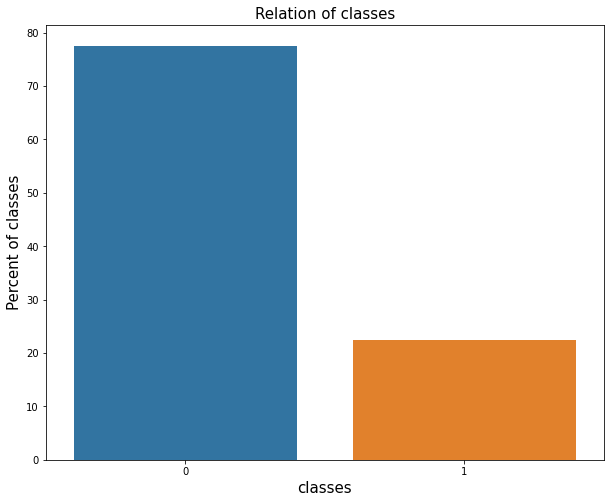

In [4]:
relation = y_data.value_counts() / len(y_data) * 100
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=relation.index, y=relation)
plt.xlabel('classes', fontsize=15)
plt.ylabel('Percent of classes', fontsize=15)
plt.title('Relation of classes', fontsize=15);

Видим, что классы несбалансированы.

# Смотрим на типы данных признаков и на пропуски

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

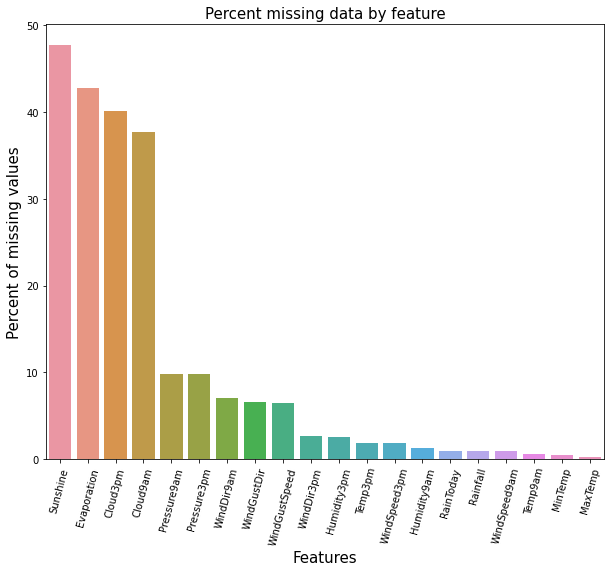

In [6]:
null_data = train_data.isnull().sum() / train_data.shape[0] * 100
null_data = null_data[null_data > 0]
null_data.sort_values(inplace=True, ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': null_data})

f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='75') #поворот подписей на 90 градусов  
sns.barplot(x=null_data.index, y=null_data)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

In [7]:
train_data.drop(['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'], inplace=True, axis=1)
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Month'] = train_data['Date'].dt.month
train_data['Month'] = train_data['Month'].astype(str)
train_data['Day'] = train_data['Date'].dt.day
train_data.drop(['Date'], inplace=True, axis=1)

In [8]:
numeric_features = train_data.dtypes[train_data.dtypes == "float64"].index
objects_features = train_data.dtypes[train_data.dtypes == "object"].index

In [9]:
for column in numeric_features:
    train_data[column].fillna(train_data[column].mean(), inplace=True)
    
for column in objects_features:
    train_data[column].fillna(train_data[column].mode()[0], inplace=True)

In [10]:
from sklearn.preprocessing import LabelEncoder

for c in objects_features:
    lbl = LabelEncoder() 
    lbl.fit(list(train_data[c].values)) 
    train_data[c] = lbl.transform(list(train_data[c].values))

In [11]:
skewed_feats = train_data[numeric_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)#Нахождение асимметрии в найденных столбцах
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})#создание ДатаФрейма для показа результата
skewness.head(20)

skewness = skewness[abs(skewness['Skew']) > 0.75]#выбор асимметрии, которая больше 0.75 по модулю
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p#Метод Бокс_Кокса для приведения к нормальному распределению
skewed_features = skewness.index
lam = 0.15#Лямбда для метода Бокс_Кокса
for feat in skewed_features:
    train_data[feat] = boxcox1p(train_data[feat], lam)


Skew in numerical features: 

There are 3 skewed numerical features to Box Cox transform


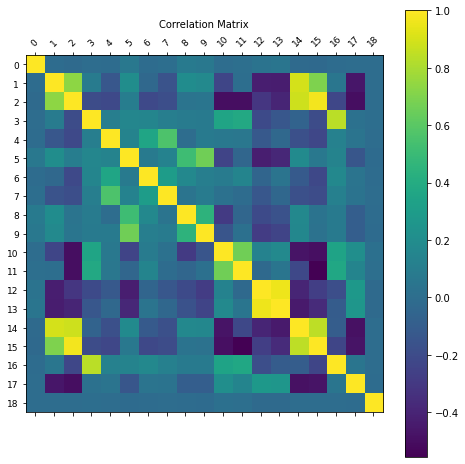

In [12]:
plot_correlation_matrix(np.corrcoef(train_data, rowvar=False))

In [13]:
train_data.drop(['Pressure9am', 'Temp9am', 'Temp3pm'], inplace=True, axis=1)

In [14]:
train_data = pd.get_dummies(train_data)

# Строим модельки

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, y_data, test_size=.25, shuffle=False)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score

# KNN

In [18]:
#knn.get_params().keys()

In [34]:
start_time = time.time()

In [35]:
knn = KNeighborsClassifier(n_neighbors=9, metric='minkowski')
knn_pipe = Pipeline([('rscl', RobustScaler()), ('clf', knn)])

In [36]:
#param_grid = [{'clf__n_neighbors' : [7, 9, 11]}]
#gs = GridSearchCV(estimator=knn_pipe,
#                  param_grid=param_grid,
#                  scoring='f1',
#                  cv=7,
#                 n_jobs=-1)
#gs = gs.fit(X_train, y_train)
#print(gs.best_score_)
#print(gs.best_params_)

#clf = gs.best_estimator_
#clf.fit(X_train, y_train)

In [37]:
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print('Accuracy: %.3f' %accuracy_score(y_pred, y_test))
print('Balanced Accuracy: %.3f' %balanced_accuracy_score(y_pred, y_test))
print('Precision: %.3f' %precision_score(y_pred, y_test))
print('Recall: %.3f' %recall_score(y_pred, y_test))
print('F1: %.3f' %f1_score(y_pred, y_test))
print('Cohen_kappa: %.3f' %cohen_kappa_score(y_pred, y_test))

Accuracy: 0.835
Balanced Accuracy: 0.776
Precision: 0.413
Recall: 0.698
F1: 0.519
Cohen_kappa: 0.427


In [38]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 72.04756712913513 seconds ---


# LOGISTIC REGRESSION

In [39]:
#logreg.get_params().keys()

In [40]:
start_time = time.time()

In [41]:
logreg = LogisticRegression(solver='saga', C=100, l1_ratio=0.7, penalty='elasticnet')
logreg_pipe = Pipeline([('scl', RobustScaler()), ('clf', logreg)])

In [42]:
#param_grid = [{'clf__penalty' : ['elasticnet'],
#              'clf__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
#              'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}]
#gs = GridSearchCV(estimator=logreg_pipe,
#                  param_grid=param_grid,
#                  scoring='f1',
#                  cv=7,
#                  n_jobs=1)
#gs = gs.fit(X_train, y_train)
#print(gs.best_score_)
#print(gs.best_params_)

#clf = gs.best_estimator_
#clf.fit(X_train, y_train)

In [43]:
logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)
print('Accuracy: %.3f' %accuracy_score(y_pred, y_test))
print('Balanced Accuracy: %.3f' %balanced_accuracy_score(y_pred, y_test))
print('Precision: %.3f' %precision_score(y_pred, y_test))
print('Recall: %.3f' %recall_score(y_pred, y_test))
print('F1: %.3f' %f1_score(y_pred, y_test))
print('Cohen_kappa: %.3f' %cohen_kappa_score(y_pred, y_test))

Accuracy: 0.849
Balanced Accuracy: 0.806
Precision: 0.450
Recall: 0.748
F1: 0.562
Cohen_kappa: 0.477


In [44]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8271474838256836 seconds ---


# NAIVE BAYES

In [45]:
start_time = time.time()

In [46]:
gauss = GaussianNB()
gauss_pipe = Pipeline([('scl', RobustScaler()), ('clf', gauss)])

In [47]:
gauss_pipe.fit(X_train, y_train)
y_pred = gauss_pipe.predict(X_test)
print('Accuracy: %.3f' %accuracy_score(y_pred, y_test))
print('Balanced Accuracy: %.3f' %balanced_accuracy_score(y_pred, y_test))
print('Precision: %.3f' %precision_score(y_pred, y_test))
print('Recall: %.3f' %recall_score(y_pred, y_test))
print('F1: %.3f' %f1_score(y_pred, y_test))
print('Cohen_kappa: %.3f' %cohen_kappa_score(y_pred, y_test))

Accuracy: 0.810
Balanced Accuracy: 0.718
Precision: 0.521
Recall: 0.564
F1: 0.542
Cohen_kappa: 0.422


In [48]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2239375114440918 seconds ---


# Итог:

Были обучены 3 модели: KNN, LOGISTIC REGRESSION, NAIVE BAYES. В силу **дисбаланса классов** целевой функции были выбраны метрики: **Balanced Accuracy, Precision, Recall, F1, Cohen Kappa**

Метрики **Precision, Recall, F1** используются в зависимости от того какой цели пытается достичь инженер. **F1** является средним гармоническим **Precision** и **Recall**, максимизация этого функционала приводит к одновременной максимизации этих двух «ортогональных критериев»

Для демонстрации ошибочности метрик неадаптированных к дисбалансу классов была выбрана метрика **Accuracy**.
Во всех 3 случаях метрика Accuracy выдавала значение выше, чем **Balanced Accuracy**, что подтверждает возможность получения ошибочно хороших значений при использовании метрики **Accuracy** при дисбалансе классов.

# Результаты работы моделей

**KNN**
Accuracy: 0.835 |
Balanced Accuracy: 0.776 |
Precision: 0.413 |
Recall: 0.698 |
F1: 0.519 |
Cohen_kappa: 0.427 |

------------------------
**LOGISTIC REGRESSION**
Accuracy: 0.849 |
Balanced Accuracy: 0.806 |
Precision: 0.450 |
Recall: 0.748 |
F1: 0.562 |
Cohen_kappa: 0.477 |

------------------------
**NAIVE BAYES**
Accuracy: 0.810 |
Balanced Accuracy: 0.718 |
Precision: 0.521 |
Recall: 0.564 |
F1: 0.542 |
Cohen_kappa: 0.422 |

Видим, что в большинстве метрик наибольшая точность у Логистической регрессии. Это может быть связано с тем, что Логистическая регрессия имеет больше всех гиперпараметров с помощью которых можно добиться более тонкой настройки модели.
Также, в наборе данных остались коррелирующие признаки, которые пагубно влияют на Наивного Байеса.

# Время работы моделей

**KNN**
72.048 seconds

---------
**LOGISTIC REGRESSION**
0.827 seconds

---------
**NAIVE BAYES**
0.224 seconds

KNN оказался самым медленным алгоритмом, так как, если в обучающей выборке N объектов, в тестовой выборе M объектов, а размерность пространства — K, то количество операций для классификации тестовой выборки может быть оценено как O(K * M * N).